# 05 - Taming Text

In [35]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment.util import *
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import pycountry
%matplotlib inline

/Users/Thomas/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [42]:
# import data
directory = 'hillary-clinton-emails/'
aliases = pd.read_csv(directory+'aliases.csv')
email_receivers = pd.read_csv(directory+'EmailReceivers.csv')
emails = pd.read_csv(directory+'Emails.csv')
persons = pd.read_csv(directory+'Persons.csv')

### Comparison between extracted body text and raw text

In [59]:
i = 2
print(emails['ExtractedBodyText'][i], '\n\n END OF BODY TEXT \n\n', emails['RawText'][i])


Thx 

 END OF BODY TEXT 

 UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From: Mills, Cheryl D <MillsCD@state.gov>
Sent: Wednesday, September 12, 2012 11:52 AM
To: B6
Cc: Abedin, Huma
Subject: Re: Chris Stevens
Thx
Original Message
From: Anne-Marie Slaughter [
Sent: Wednesday, September 12, 2012 07:46 AM
To: Ihdr22@clintonernail.com' <hdr22@clintonemail corn>
Cc: Abed in, Huma; Mills, Cheryl D
Subject: Chris Stevens
To you and all my former colleagues, I'm so terribly sorry. Our FSOs stand on the front lines just as surely and devotedly
as our soldiers do. Thinking of you and Pat and everyone this morning.
AM
UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE IN

By reading a few emails we can see that the extracted body text is just the text that the email sender wrote (as stated on Kaggle) while the raw text gathers the previous emails forwarded or the whole discussion. Note that the extracted body text can sometimes contain NaNs. By including repeated messages in the raw text, you induce bias in the distribution of the words, thus we kept only the body text

## 1. Worldclouds

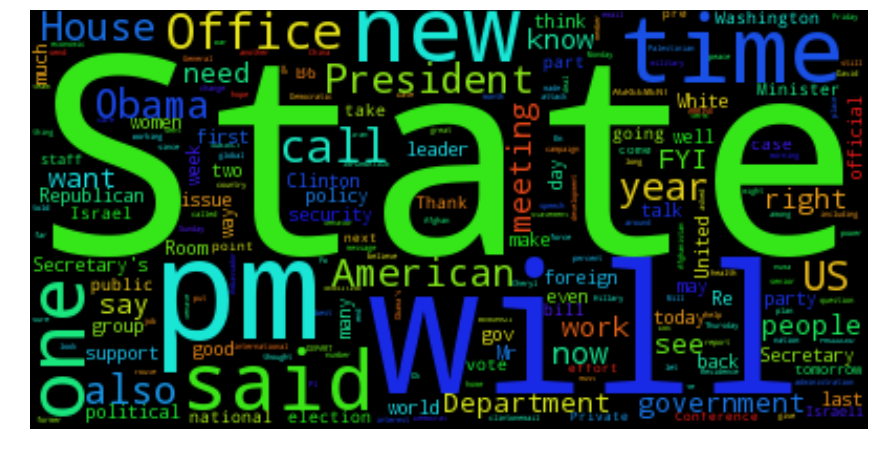

In [63]:
# raw corpus
text_corpus = emails.ExtractedBodyText.dropna().values
raw_text = ' '.join(text_corpus)

# generate wordcloud
wordcloud = WordCloud().generate(raw_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off');

In [64]:
def preprocess(text=raw_text):
    print('Length of raw text: ', len(raw_text))
    
    # tokenization (need to install models/punk from nltk.download())
    tokens = nltk.word_tokenize(raw_text, language='english')
    print('Number of tokens extracted: ', len(tokens))
    
    # stopwords removal (need to install stopwords corpus in corpora/stopwords)
    # cach stopwords to improve performance (70x speedup)
    cached_stopwords = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in cached_stopwords]
    print('Number of tokens after stopword removal: ', len(filtered_tokens))
    
    # stemming
    stemmer = nltk.SnowballStemmer('english')
    stemmed_filtered_tokens = [stemmer.stem(t) for t in filtered_tokens]
    
    # dump array in text file
    output = ' '.join(stemmed_filtered_tokens)
    with open("preprocessed_text.txt", "w") as text_file:
        text_file.write(output)
        
preprocess()

Length of raw text:  3601322
Number of tokens extracted:  697009
Number of tokens after stopword removal:  475544


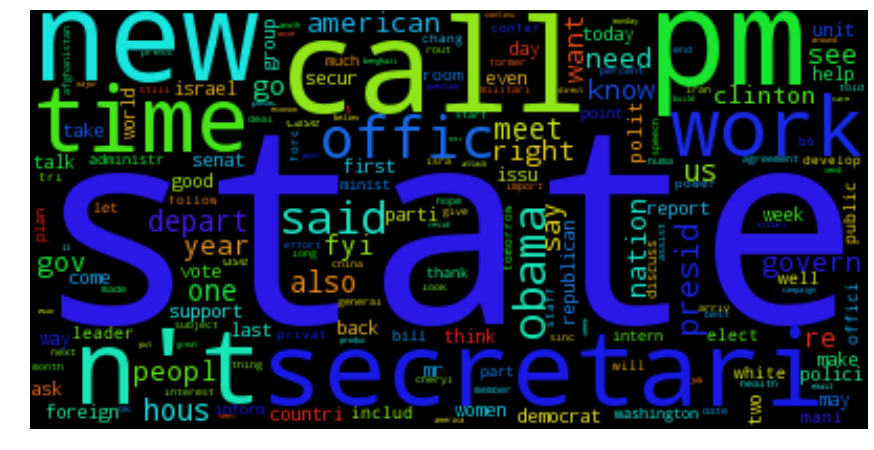

In [65]:
preprocessed_text = open('preprocessed_text.txt').read()
wordcloud2 = WordCloud().generate(preprocessed_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud2)
plt.axis('off');

## Comparison between the word clouds

Looking at the wordcloud generated after having preprocessed the data, it seems that stemming hurt the "performance" of the wordcloud, indeed a number of words have been incorrectly stemmed e.g. department has been reduced to depart, secretary to secretary, message to messag and so on.

## 2. Sentiment analysis

In [66]:
list(pycountry.countries)[0]

Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533')